In [1]:
import numpy as np
import sklearn
from skimage import transform
import matplotlib.pyplot as plt
from scipy.misc import face
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning

(768, 1024)


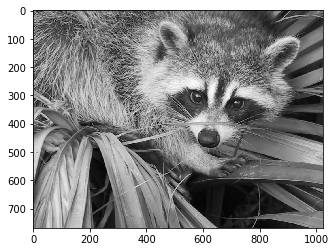

(384, 512)


In [2]:
# Step 1: Load the image
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)
    
print(face.shape)
plt.imshow(face, cmap='gray')
plt.show() 
H, W = face.shape
pH, pW = 4,4
face = transform.resize(face, (H//2,W//2), mode="constant")
print(face.shape)

Number of patches: 30000
Visualization of some patches


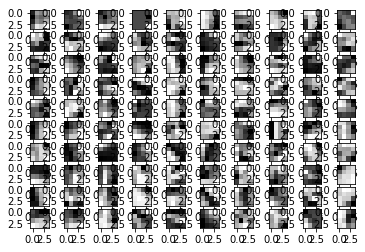

In [3]:
# Step 2: Sample the patches from the image to learn. 
# Let set the number of patches to 30000
nbpatch = 30000
patches = extract_patches_2d(face, (pH, pW), nbpatch)
print('Number of patches: %d' %patches.shape[0],)

# randomly shuffle the patches
np.random.shuffle(patches)

print('Visualization of some patches')
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(patches[i*10+j,...], cmap='gray')
plt.show()

In [4]:
# Step 3: Normalize the data to train the dictionary

# create matrix X as a reshape of the patches 
# X has the shape (num_patches x num_features)
X = patches.reshape(nbpatch, pH*pW)


# convert X to float type (np.float64)
X.astype(np.float64, copy = False)

# Subtract mean and divide X by its standard deviation
X = (X - X.mean(axis=0))/X.std(axis=0)


In [5]:
# Step 4: Learn the dictionary from the patches
# create MiniBatchDictionaryLearning object
# with: 64 components, alpha = 1, 500 iterations
# using 'lars' algorithm and use sparse coding with 6 non-zero coefficients
d_learner = MiniBatchDictionaryLearning(n_components=64, alpha=1, n_iter=500, fit_algorithm='lars', transform_n_nonzero_coefs=6)
# learn the dictionary
d_learner.fit(X)
# get the dictionary
D = d_learner.components_
print(D.shape)

(64, 16)


In [6]:
# Utility functions
def sample_patches(im, pH, pW):
    H, W = im.shape
    patches = list([])
    n = H // pH
    m = W // pW
    for i in range(n):
        for j in range(m):
            patch = im[i * pH:(i+1) * pH, j * pW : (j+1) * pW]
            patches.append(patch.reshape([1,-1]))
    patches = np.vstack(patches)
    return patches

def patches_to_img(patches, pH, pW, H, W):
    im = np.zeros((H,W))
    n = H // pH
    m = W // pW
    for i in range(n):
        for j in range(m):
            im[i * pH:(i+1) * pH, j * pW : (j+1) * pW] = patches[i*m+j]
    return im

In [7]:
# Step 5: prepare patches to run the reconstruction
patches = sample_patches(face, pH, pW)
patches = patches.astype(np.float64)
mean = patches.mean(axis=0)
patches -= mean

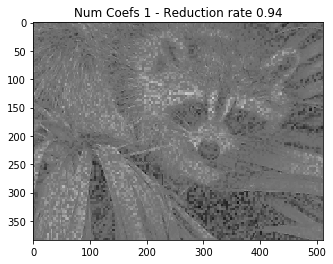

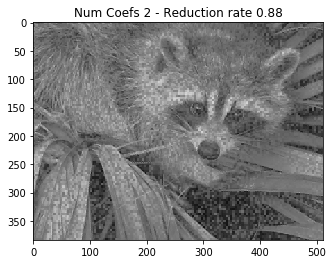

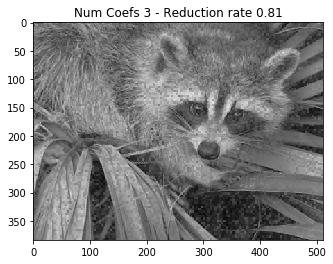

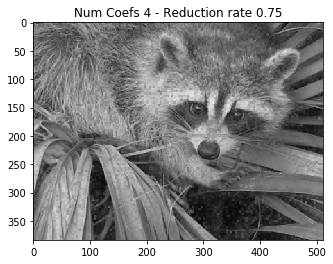

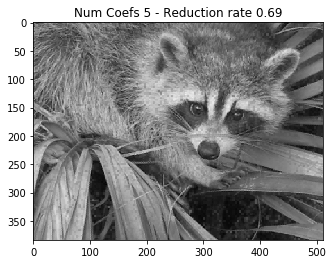

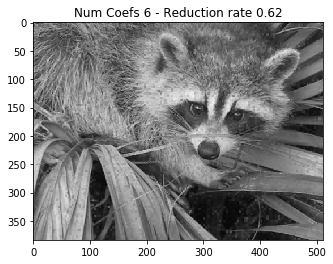

In [9]:
# Step 6: Reconstruct the image with different number of non-zero coefficients
transform_algorithms = [
     {'transform_n_nonzero_coefs': 1},
     {'transform_n_nonzero_coefs': 2},
     {'transform_n_nonzero_coefs': 3},
     {'transform_n_nonzero_coefs': 4},
     {'transform_n_nonzero_coefs': 5},
     {'transform_n_nonzero_coefs': 6},
]
for kwargs in transform_algorithms:
    d_learner.set_params(transform_algorithm='lars', **kwargs)
    # find the sparse representaion fo the patches
    sparse_reps = d_learner.transform(patches)
    
    # reconstruct the patches from their sparse representations and the learned dictionary
    recon_patches = sparse_reps @ D
    
    # add the mean to the reconstruction
    recon_patches += mean
    
    # reshape recon_patches to num_patches x pH x pW
    recon_patches = recon_patches.reshape(-1, pH, pW)
    
    # put all the patches back into the reconstructed image
    recon = patches_to_img(recon_patches, pH, pW, H//2, W//2)
    
    plt.imshow(recon, cmap='gray', vmin=0, vmax=1)
    plt.title('Num Coefs %d - Reduction rate %.02f' %(kwargs['transform_n_nonzero_coefs'], 
                                                   (1.0 - float(kwargs['transform_n_nonzero_coefs']) / (pH * pW)) ))
    plt.show()